In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as trans
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets
import matplotlib.pyplot as plt
import os
from PIL import Image
import time

In [2]:
device = ('cuda' if torch.cuda.is_available() else "cpu")
device

'cuda'

## Image Transformation

In [3]:
transform = trans.Compose([
    trans.Resize((224,224)),
    trans.ToTensor(),
    trans.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

## Loading the dataset

In [15]:
from pathlib import Path
from torchvision import datasets

BASE_DIR = Path("Fruits Classification")

train_dataset = datasets.ImageFolder(
    BASE_DIR / "train",
    transform=transform
)

val_dataset = datasets.ImageFolder(
    BASE_DIR / "valid",   # or "val" depending on your folder name
    transform=transform
)

test_dataset = datasets.ImageFolder(
    BASE_DIR / "test",
    transform=transform
)

In [16]:
# train_dataset = datasets.ImageFolder(
#     '/content/drive/My Drive/Fruits Classification/train',
#     transform=transform
# )

# val_dataset = datasets.ImageFolder(
#     '/content/drive/My Drive/Fruits Classification/test',
#     transform=transform
# )

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


## Getting the dataset info

In [17]:
def get_dataset_info(dataset):
    print(f"Number of classes: {len(dataset.classes)}")
    print(f"Class names: {dataset.classes}")
    print(f"Number of images: {len(dataset)}")
    class_counts = {cls: 0 for cls in dataset.classes} # This creates a dictionary with key as class_name and value initially as 0
    for _, label in dataset.samples:                # dataset.samples contain tuples with (image_path, labels)
        class_counts[dataset.classes[label]] +=1   # it counts how many times a label has been encountered in the dataset, i.e:- number of images in that particular label
    print("Class Distribution")
    for cls, counts in class_counts.items():
        print(f"{cls}: {counts}")

# Get the dataset info
print("Training dataset info:- ")
get_dataset_info(train_dataset)
print("Validation dataset info:-")
get_dataset_info(val_dataset)


Training dataset info:- 
Number of classes: 5
Class names: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']
Number of images: 9700
Class Distribution
Apple: 1940
Banana: 1940
Grape: 1940
Mango: 1940
Strawberry: 1940
Validation dataset info:-
Number of classes: 5
Class names: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']
Number of images: 200
Class Distribution
Apple: 40
Banana: 40
Grape: 40
Mango: 40
Strawberry: 40


## Loading the pre-trained ResNet50 model

In [7]:
model = models.resnet50(pretrained = True)


c:\Users\wei10\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\wei10\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
0.3%

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\wei10/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100.0%


In [8]:
# Modify the classifier for custom classes
num_ftrs = model.fc.in_features  # This gives the number of input features to the final fully connected layer
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))  # Replaces the final classification layer to the new fully connected layer
model = model.to(device)

## Loss function and Optimisers

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)

## Model Training

In [10]:
# Training Loop
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    start_time = time.time()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            total += labels.size(0)
            correct += predictions.eq(labels).sum().item()
        print(f"{epoch}/{epochs}, loss:- {running_loss/len(train_loader):.4f}, Acuracy:- {100*(correct/total)}")
    end_time = time.time()
    print(f"Total training time:- {end_time - start_time:.2f} seconds")

## Model Evaluation

In [11]:
# Evaluation function
def evaluate(model, val_loader, criterion):
    model.eval()
    total = 0
    correct = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item()
            _, predictions = output.max(1)
            total += labels.size(0)
            correct += predictions.eq(labels).sum().item()

    print(f" Validation loss:- {val_loss:.4f}, Validation accuracy:- {100*(correct/total)}")

## Model Inferencing

In [12]:
def infer(model, image_path, transform):
    model.eval()
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predictions= output.max(1)
    class_name = train_dataset.classes[predictions.item()]
    print(f"Predicted class is :- {class_name}")
    return class_name

## Visualising the prediction

In [13]:
def visualise_prediction(model, val_loader, transform):
    model.eval()
    images, labels= next(iter(val_loader))
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        output = model(images)
        _, prediction = torch.max(output, 1)

    fig = plt.figure(figsize=(10,10))
    for i in range(9):
        ax = fig.add_subplot(3,3,i+1, xticks = [], yticks = [])
        img = images[i].cpu().numpy().transpose((1,2,0))
        img = img * np.array([0.229,0.225,0.224]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0,1)
        ax.imshow(img)
        ax.set_title(f"Pred: {train_dataset.classes[prediction[i].item()]}")
    plt.show()

0/10, loss:- 0.6040, Acuracy:- 78.78350515463917
1/10, loss:- 0.4031, Acuracy:- 85.83505154639175
2/10, loss:- 0.3697, Acuracy:- 86.85567010309279
3/10, loss:- 0.3587, Acuracy:- 87.20618556701031
4/10, loss:- 0.3428, Acuracy:- 87.76288659793813
5/10, loss:- 0.3191, Acuracy:- 88.69072164948454
6/10, loss:- 0.3137, Acuracy:- 88.74226804123711
7/10, loss:- 0.3211, Acuracy:- 88.56701030927834
8/10, loss:- 0.3087, Acuracy:- 88.97938144329896
9/10, loss:- 0.2957, Acuracy:- 89.61855670103093
Total training time:- 449.70 seconds
 Validation loss:- 1.8153, Validation accuracy:- 89.5


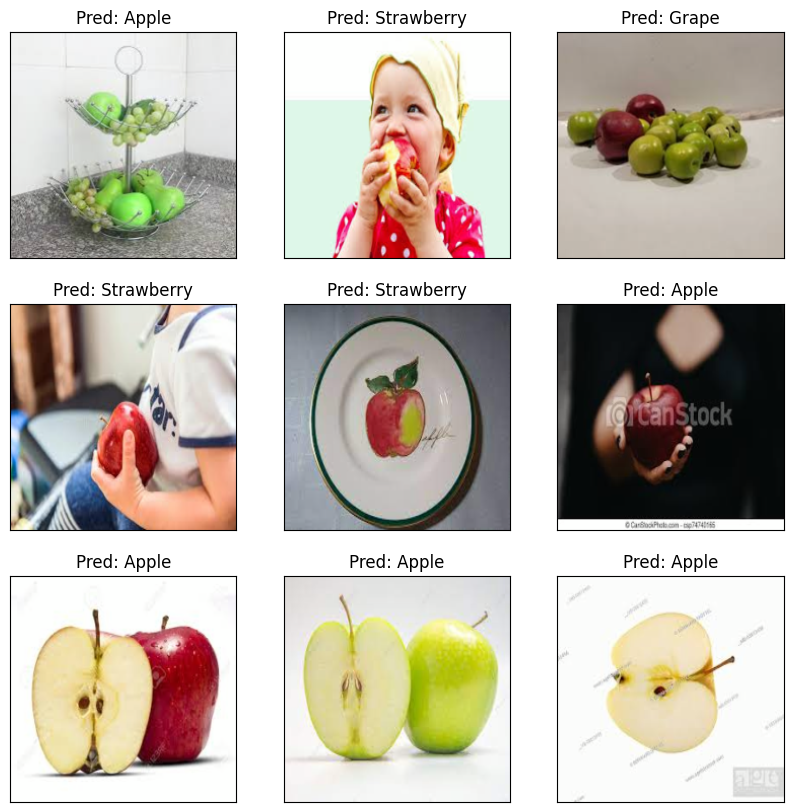

In [18]:
# train and evaluate the model
train(model, train_loader,criterion, optimizer, epochs = 10)
evaluate(model, val_loader, criterion)

# Visualise predicitons
visualise_prediction(model, val_loader, transform)